# Birch clustering on Credit card dataset

Libraries : 

In [1]:
# Birch for Clustering
from sklearn.cluster import Birch

# Essentials:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# t-SNE visualization
from sklearn.manifold import TSNE

# imputation
from sklearn.impute import KNNImputer

# Scaling
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# K-means for Clustering
from sklearn.cluster import KMeans

# elbow method
from yellowbrick.cluster import KElbowVisualizer

# cluster metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

# Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score

Take a look at dataset : 

In [2]:
cc_general = pd.read_csv('/content/CC_GENERAL.csv')
cc_general.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


Understand the features : 

In [3]:
cc_general.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


check the missing values :

In [4]:
cc_general.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Check for outliers:

In [5]:
def outlier_percent(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) |(data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

In [6]:
non_categorical_data = cc_general.drop(['CUST_ID'], axis=1)
for column in non_categorical_data.columns:
    data = non_categorical_data[column]
    percent = str(round(outlier_percent(data), 2))
    print(f'Outliers in "{column}": {percent}%')

Outliers in "BALANCE": 7.77%
Outliers in "BALANCE_FREQUENCY": 16.68%
Outliers in "PURCHASES": 9.03%
Outliers in "ONEOFF_PURCHASES": 11.32%
Outliers in "INSTALLMENTS_PURCHASES": 9.69%
Outliers in "CASH_ADVANCE": 11.51%
Outliers in "PURCHASES_FREQUENCY": 0.0%
Outliers in "ONEOFF_PURCHASES_FREQUENCY": 8.74%
Outliers in "PURCHASES_INSTALLMENTS_FREQUENCY": 0.0%
Outliers in "CASH_ADVANCE_FREQUENCY": 5.87%
Outliers in "CASH_ADVANCE_TRX": 8.98%
Outliers in "PURCHASES_TRX": 8.56%
Outliers in "CREDIT_LIMIT": 2.77%
Outliers in "PAYMENTS": 9.03%
Outliers in "MINIMUM_PAYMENTS": 9.74%
Outliers in "PRC_FULL_PAYMENT": 16.47%
Outliers in "TENURE": 15.26%


# Preprocessing: 

remove the outliers:

In [7]:
for column in non_categorical_data.columns:
    data = non_categorical_data[column]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
 
    outliers = ((data < minimum) |(data > maximum))
    non_categorical_data[column].loc[outliers] = np.nan
    
non_categorical_data.isnull().sum()

BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
CREDIT_LIMIT                         249
PAYMENTS                             808
MINIMUM_PAYMENTS                    1154
PRC_FULL_PAYMENT                    1474
TENURE                              1366
dtype: int64

# Imputing the missing data

I use KNN imputer

In [8]:
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(non_categorical_data), columns=non_categorical_data.columns)
imp_data.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

# Scale the Data:

I use StandardScaler

In [9]:
std_imp_data = pd.DataFrame(StandardScaler().fit_transform(imp_data), columns=imp_data.columns)
std_imp_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8.950000e+03,8950.0
mean,1.459292e-16,3.641780e-15,-3.845664e-15,8.330072e-15,9.068103e-16,8.933760e-16,-3.716084e-16,-7.758809e-15,2.353921e-16,-9.233334e-16,-7.427330e-17,9.962980e-16,4.909878e-15,4.842805e-16,-2.008573e-16,-2.921344e-15,0.0
std,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,1.000056e+00,0.0
min,-9.711973e-01,-4.155613e+00,-9.108875e-01,-6.679045e-01,-7.876755e-01,-6.489418e-01,-1.221758e+00,-7.446281e-01,-9.169952e-01,-7.472686e-01,-6.819606e-01,-9.664084e-01,-1.365191e+00,-1.191542e+00,-1.158882e+00,-4.495377e-01,0.0
25%,-8.704482e-01,3.667368e-01,-8.520982e-01,-6.679045e-01,-7.876755e-01,-6.489418e-01,-1.014125e+00,-7.446281e-01,-9.169952e-01,-7.472686e-01,-6.819606e-01,-8.736091e-01,-8.652204e-01,-8.088997e-01,-7.803523e-01,-4.495377e-01,0.0
50%,-2.883274e-01,3.667368e-01,-3.757635e-01,-5.868463e-01,-4.754304e-01,-6.489418e-01,2.404259e-02,-3.780223e-01,-4.976286e-01,-7.472686e-01,-6.819606e-01,-3.168136e-01,-4.136338e-01,-3.375007e-01,-4.237788e-01,-4.495377e-01,0.0
75%,5.646491e-01,3.667368e-01,6.126365e-01,3.671317e-01,5.319986e-01,5.416827e-01,1.062211e+00,4.485112e-01,9.701506e-01,4.368733e-01,4.783950e-01,6.111790e-01,6.508204e-01,6.738027e-01,6.386496e-01,-2.118108e-01,0.0
max,2.911266e+00,3.667368e-01,3.120231e+00,3.512681e+00,3.318839e+00,3.337571e+00,1.269843e+00,2.554838e+00,1.599199e+00,3.128100e+00,3.185891e+00,2.838361e+00,3.005522e+00,2.978873e+00,2.852750e+00,4.305014e+00,0.0


## Dimention Reduction using PCA

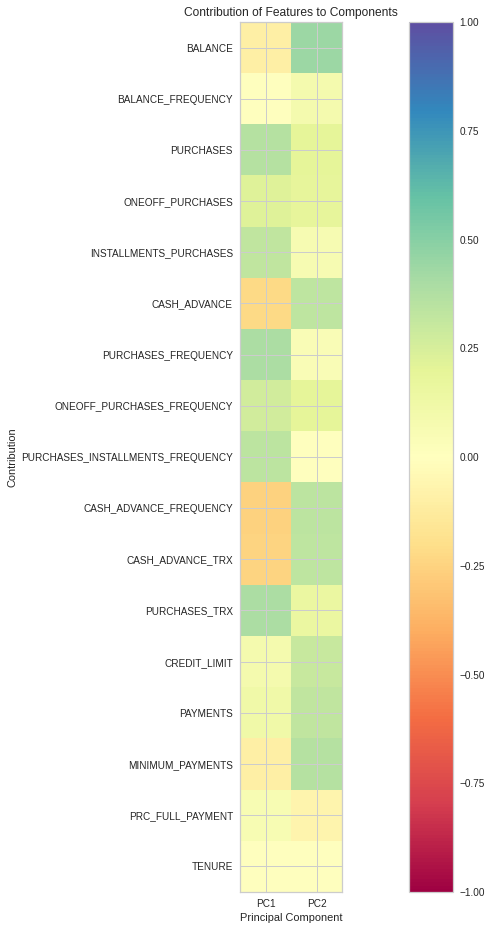

In [10]:
pca = PCA(n_components=2, random_state=42)
pca.fit(std_imp_data)
PC_names = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]


pca_data = pd.DataFrame(pca.transform(std_imp_data), columns=PC_names)


fig, ax = plt.subplots(figsize=(24, 16))
plt.imshow(pca.components_.T,
           cmap="Spectral",
           vmin=-1,
           vmax=1,
          )
plt.yticks(range(len(std_imp_data.columns)), std_imp_data.columns)
plt.xticks(range(len(pca_data.columns)), pca_data.columns)
plt.xlabel("Principal Component")
plt.ylabel("Contribution")
plt.title("Contribution of Features to Components")
plt.colorbar()

# Number of clusters? 

### 1) Optimize n_clusters with Elbow:

In [11]:
wcss = []

for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

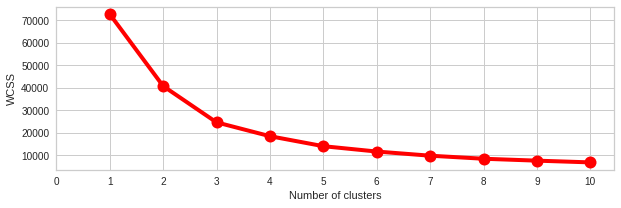

In [12]:
fig = plt.figure(figsize = (10,3))
plt.plot(range(1,11), wcss,
         linewidth=4, markersize=12, marker='o', color = 'red')
plt.xticks(np.arange(11))
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

Here n_clusters is 3!

### Optimize n_clusters with Silhouette_score :

In [13]:
def visualize_silhouette(cluster_lists, X_features): 

    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0, init = 'k-means++')
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
   
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

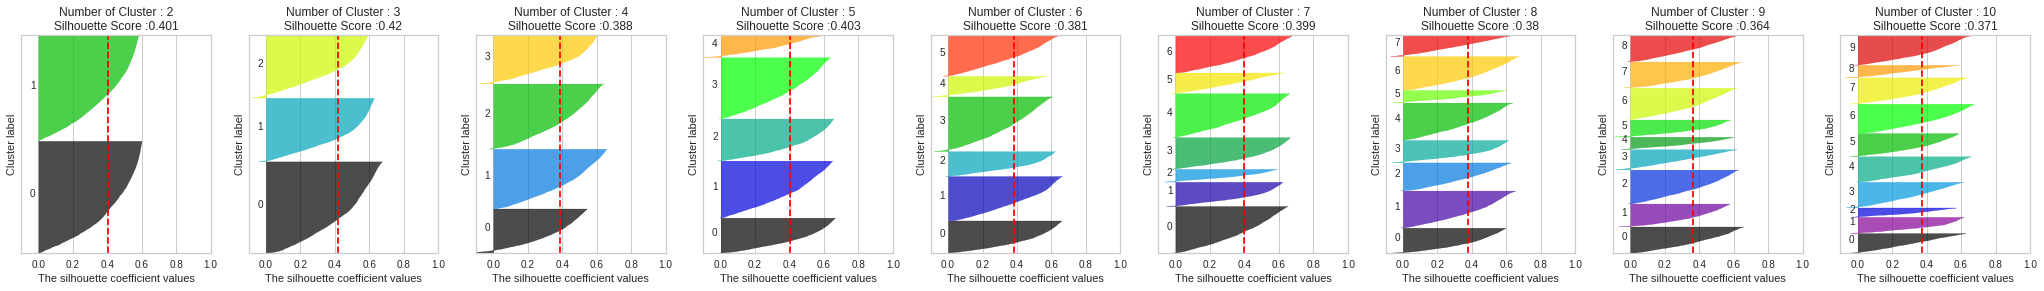

In [14]:
visualize_silhouette([2, 3, 4, 5, 6, 7, 8, 9, 10], pca_data)

# Train the Model: 

So, I set n_clusters = 3.

In [15]:
model = Birch(threshold=1.7, n_clusters=3)
y_birch = model.fit_predict(pca_data)

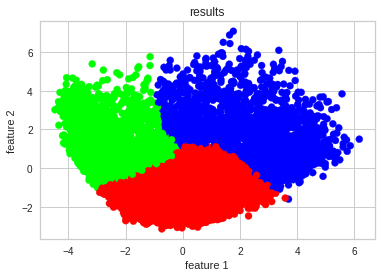

In [16]:
plt.scatter(pca_data['PC1'], pca_data['PC2'], c=y_birch,
            cmap='brg')
plt.title('results')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.show()